
Skipping file dictionary_0.csv, as it is not a valid image.
Loaded 34 valid images, skipped 1 invalid images.
Dataset shape: (34, 64, 64, 3)


1/1 [==============================] - 0s 455ms/step


0 [D loss: 0.6885771155357361, acc.: 28.125] [G loss: 0.6026811599731445]
1/1 [==============================] - 0s 251ms/step


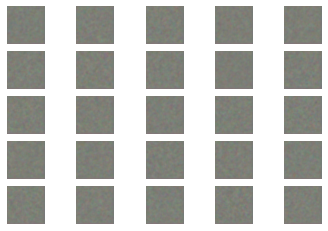

1/1 [==============================] - 0s 191ms/step
1 [D loss: 0.526229590177536, acc.: 50.0] [G loss: 0.5440101027488708]
1/1 [==============================] - 0s 209ms/step
2 [D loss: 0.4510597288608551, acc.: 50.0] [G loss: 0.5121221542358398]
1/1 [==============================] - 0s 192ms/step
3 [D loss: 0.4067322462797165, acc.: 75.0] [G loss: 0.45059990882873535]
1/1 [==============================] - 0s 214ms/step
4 [D loss: 0.363608967512846, acc.: 100.0] [G loss: 0.3907518982887268]
1/1 [==============================] - 0s 188ms/step
5 [D loss: 0.34147556126117706, acc.: 100.0] [G loss: 0.3312176465988159]
1/1 [==============================] - 0s 193ms/step
6 [D loss: 0.381269957870245, acc.: 51.5625] [G loss: 0.28162696957588196]
1/1 [==============================] - 0s 226ms/step
7 [D loss: 0.5025086030364037, acc.: 50.0] [G loss: 0.2748118042945862]
1/1 [==============================] - 0s 200ms/step
8 [D loss: 0.4997379370033741, acc.: 50.0] [G loss: 0.4197956919670

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from PIL import UnidentifiedImageError

# Step 2: Load and Preprocess Dataset
def load_images_from_folder(folder, image_size=(64, 64)):
    images = []
    valid_files = 0
    invalid_files = 0
    for filename in os.listdir(folder):
        try:
            img = load_img(os.path.join(folder, filename), target_size=image_size)
            if img is not None:
                images.append(img_to_array(img))
                valid_files += 1
            else:
                invalid_files += 1
        except (UnidentifiedImageError, OSError):
            print(f"Skipping file {filename}, as it is not a valid image.")
            invalid_files += 1
    print(f"Loaded {valid_files} valid images, skipped {invalid_files} invalid images.")
    return np.array(images)

dataset = load_images_from_folder('./Data/fits_filtered8')
print(f"Dataset shape: {dataset.shape}")
if dataset.size == 0:
    raise ValueError("No valid images found in the dataset. Please check the image files.")
dataset = (dataset - 127.5) / 127.5  # Normalize to [-1, 1]

# Step 3: Build the GAN

# Generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128 * 16 * 16, activation="relu", input_dim=100))
    model.add(layers.Reshape((16, 16, 128)))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=4, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=4, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
    model.add(layers.Conv2D(3, kernel_size=4, padding="same"))
    model.add(layers.Activation("tanh"))
    return model

# Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, input_shape=(64, 64, 3), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates images
z = layers.Input(shape=(100,))
img = generator(z)

# For the combined model, only the generator is trained
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Step 4: Train the GAN

import numpy as np

# Training parameters
epochs = 100
batch_size = 64
save_interval = 1000

# Load and preprocess the dataset
X_train = dataset
half_batch = int(batch_size / 2)

# Training the GAN
for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)

    g_loss = combined.train_on_batch(noise, valid_y)

    print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1

        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

# Step 5: Generate New Data

noise = np.random.normal(0, 1, (10, 100))
gen_imgs = generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1

for i in range(10):
    plt.imshow(gen_imgs[i])
    plt.axis('off')
    plt.show()
